**Pipeline** for running tabPFN and AutoGluon together and make an ensemble. Made to run in Colab or StudioLab

In [ ]:
### installments

!pip install autogluon
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz
!pip install tabpfn
!pip install sklearn
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 804.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.0/428.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jamm

In [1]:
# All imports

from autogluon.tabular import TabularDataset, TabularPredictor

import pandas as pd
import numpy as np
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, r2_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

from IPython.display import Image, display

from datetime import datetime, timedelta


In [2]:
# Connect to drive for dataaccess

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/361098'

Mounted at /content/drive


In [3]:
random_seed = 42

In [39]:
## Function for loading one of the 10 folds of the property dataset and concatinating the X and y values for train and test respectively.

#base_path = '../../data/361092' # Use this when running locally

def load_fold(fold_number, random_seed=random_seed, sample_size=None, concat_test=False):
    df_X_train = pd.read_parquet(f'{base_path}/{fold_number}/X_train.parquet')
    df_y_train = pd.read_parquet(f'{base_path}/{fold_number}/y_train.parquet')
    df_X_test = pd.read_parquet(f'{base_path}/{fold_number}/X_test.parquet')
    df_y_test = pd.read_parquet(f'{base_path}/{fold_number}/y_test.parquet')

    # concatinating the X and y values for train (and test), but keeping for test
    df_train = pd.concat([df_X_train, df_y_train], axis=1)


    # Convert to AutoGluon's TabularDataset
    if concat_test:
        df_test = pd.concat([df_X_test, df_y_test], axis=1)
        train_dataset = TabularDataset(df_train)
        test_dataset = TabularDataset(df_test)

        return train_dataset, test_dataset

    train_dataset = TabularDataset(df_train)
    test_dataset_X = TabularDataset(df_X_test)
    test_dataset_y = TabularDataset(df_y_test)

    return train_dataset, test_dataset_X, test_dataset_y

# Also instantiate the target column
label = 'total_(BRL)'
dataset_name = 'Brazil'


In [5]:
## Function to fit the model using AutoGluon

def fit_gluon(train_dataset, problem_type='regression', hyperparameters=None, eval_metric='r2', presets='medium_quality', time_limit=100, fit_weighted_ensemble=None, num_cpus = None, num_gpus=None, auto_stack=None, num_bag_folds=None, num_bag_sets=None, num_stack_levels=None, num_trials=None, verbosity=None, ag_args_fit=None, feature_prune=None, excluded_model_types=None, keep_only_best=None):
    predictor = TabularPredictor(label=label_property, problem_type=problem_type, eval_metric=eval_metric)

    fit_args = {
        'train_data': train_dataset,
        'presets': presets,
        'time_limit': time_limit,
    }

    if hyperparameters is not None:
        fit_args['hyperparameters'] = hyperparameters
    if auto_stack is not None:
        fit_args['auto_stack'] = auto_stack
    if num_bag_folds is not None:
        fit_args['num_bag_folds'] = num_bag_folds
    if num_bag_sets is not None:
        fit_args['num_bag_sets'] = num_bag_sets
    if num_stack_levels is not None:
        fit_args['num_stack_levels'] = num_stack_levels
    if num_trials is not None:
        fit_args['num_trials'] = num_trials
    if verbosity is not None:
        fit_args['verbosity'] = verbosity
    if ag_args_fit is not None:
        fit_args['ag_args_fit'] = ag_args_fit
    if feature_prune is not None:
        fit_args['feature_prune'] = feature_prune
    if excluded_model_types is not None:
        fit_args['excluded_model_types'] = excluded_model_types
    if fit_weighted_ensemble is not None:
        fit_args['fit_weighted_ensemble'] = fit_weighted_ensemble
    if num_cpus is not None:
        fit_args['num_cpus'] = num_cpus
    if num_gpus is not None:
        fit_args['num_gpus'] = num_gpus
    if keep_only_best is not None:
        fit_args['keep_only_best'] = keep_only_best

    predictor.fit(**fit_args)
    return predictor



In [6]:
## Function to evaluate the predictor

def evaluate_gluon(model, test_dataset):

    leaderboard = model.leaderboard(test_dataset, only_pareto_frontier=True)

    y_test = test_dataset[label_property]
    x_test = test_dataset.drop(columns=[label_property])
    y_pred = model.predict(x_test)
    test_score = model.evaluate_predictions(y_true=y_test, y_pred=y_pred)

    path_to_png = model.plot_ensemble_model()
    L2_diagram = Image(filename=path_to_png)


    return test_score, leaderboard, L2_diagram

In [7]:
## Making sets of all 10 folds

full_train = None
full_test_X = None
full_test_y = None

for fold_number in range(1, 11):
    train_dataset, test_dataset_X, test_dataset_y = load_fold(fold_number, random_seed=random_seed)
    if full_train is None:
        full_train = train_dataset
        full_test_X = test_dataset_X
        full_test_y = test_dataset_y
    else:
        # Use pd.concat to combine TabularDatasets
        full_train = pd.concat([full_train, train_dataset])
        full_test_X = pd.concat([full_test_X, test_dataset_X])
        full_test_y = pd.concat([full_test_y, test_dataset_y])

In [8]:
## Function to turn the target variable into 10 equally distributed classes


def create_interval_classes(df, target_column, n_intervals=10):
    """
    Create equally distributed interval classes for the target variable.

    :param df: DataFrame containing the target variable
    :param target_column: Name of the target variable column
    :param n_intervals: Number of intervals to create (default 10)
    :return: DataFrame with new 'interval_class' column and interval boundaries
    """
    # Extract target values
    target_values = df[target_column].values

    # Calculate interval boundaries
    interval_boundaries = np.percentile(target_values, np.linspace(0, 100, n_intervals+1))

    # Create interval labels
    interval_labels = [f'Interval_{i+1}' for i in range(n_intervals)]

    # Assign interval classes
    df['interval_class'] = pd.cut(df[target_column],
                                  bins=interval_boundaries,
                                  labels=interval_labels,
                                  include_lowest=True)

    return df, interval_boundaries

In [9]:
## Convert to numeric to run in TabPFN. Remember to use original for Autogluon

def convert_to_numeric(df, categorical_columns):
    for col in categorical_columns:
        if df[col].dtype.name == 'category':
            df[col] = df[col].cat.codes.astype('float64')
        else:
            # If it's not categorical, ensure it's numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

categorical_columns = full_train.select_dtypes(include=['category']).columns

print(full_train.dtypes)

full_train_numeric = convert_to_numeric(full_train, categorical_columns)
full_test_X_numeric = convert_to_numeric(full_test_X, categorical_columns)

city                    category
area                       int64
rooms                      uint8
bathroom                   uint8
parking_spaces             uint8
animal                  category
furniture               category
hoa_(BRL)                  int64
rent_amount_(BRL)          int64
property_tax_(BRL)         int64
fire_insurance_(BRL)       int64
total_(BRL)              float64
dtype: object


In [10]:
## Create interval classes for the full dataset

full_train_w_interval, boundaries = create_interval_classes(full_train_numeric, label)

# Make sure full_train does not have this feature
full_train = full_train.drop(columns = ['interval_class']) if 'interval_class' in full_train.columns else full_train

# Create df for training with TabPFN
train_for_tabpfn = full_train_w_interval.drop(columns=[label])
train_for_feature_engineering = train_for_tabpfn.drop(columns=['interval_class'])

In [ ]:
print("Train dtypes after conversion:")
print(train_for_tabpfn.dtypes)
print(train_for_tabpfn['interval_class'].value_counts())
print("\nTest dtypes after conversion:")
print(full_test_X.dtypes)

Train dtypes after conversion:
oz1                float64
oz2                float64
oz3                float64
oz4                float64
oz5                float64
                    ...   
oz248              float64
oz249              float64
oz250              float64
oz251              float64
interval_class    category
Length: 63, dtype: object
interval_class
Interval_5     8190
Interval_2     8109
Interval_1     8019
Interval_7     8001
Interval_9     7992
Interval_10    7992
Interval_8     7956
Interval_3     7938
Interval_4     7929
Interval_6     7839
Name: count, dtype: int64

Test dtypes after conversion:
oz1      float64
oz2      float64
oz3      float64
oz4      float64
oz5      float64
          ...   
oz247    float64
oz248    float64
oz249    float64
oz250    float64
oz251    float64
Length: 62, dtype: object


In [14]:
## Function to fit the model using TabPFN

def fit_tabpfn(data=full_train_w_interval, n=1000, device='cpu', N_ensemble_configurations=None, random_seed=random_seed, target='interval_class'):
    if N_ensemble_configurations is None:
        classifier = TabPFNClassifier(device=device)
    else:
        classifier = TabPFNClassifier(device=device, N_ensemble_configurations=N_ensemble_configurations)

    sample_full_train = train_for_tabpfn.sample(n=n, random_state=random_seed)

    X_train = sample_full_train.drop(columns=[target])
    y_train = sample_full_train[target]

    classifier.fit(X_train, y_train)

    return classifier, sample_full_train


In [15]:
## Fit the TabPFN model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

classifier, sample = fit_tabpfn(data=train_for_tabpfn, n=1000, device=device, N_ensemble_configurations=None, random_seed=random_seed)



Using device: cuda


In [30]:
"""## Delete the sample data from the TabPFN training data
train_for_feature_engineering = train_for_feature_engineering.drop(sample.index)
full_train = full_train.drop(sample.index)
full_train_w_interval = full_train_w_interval.drop(sample.index)
"""
print(len(full_train_w_interval))
print(len(train_for_feature_engineering))

87696
87696


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning

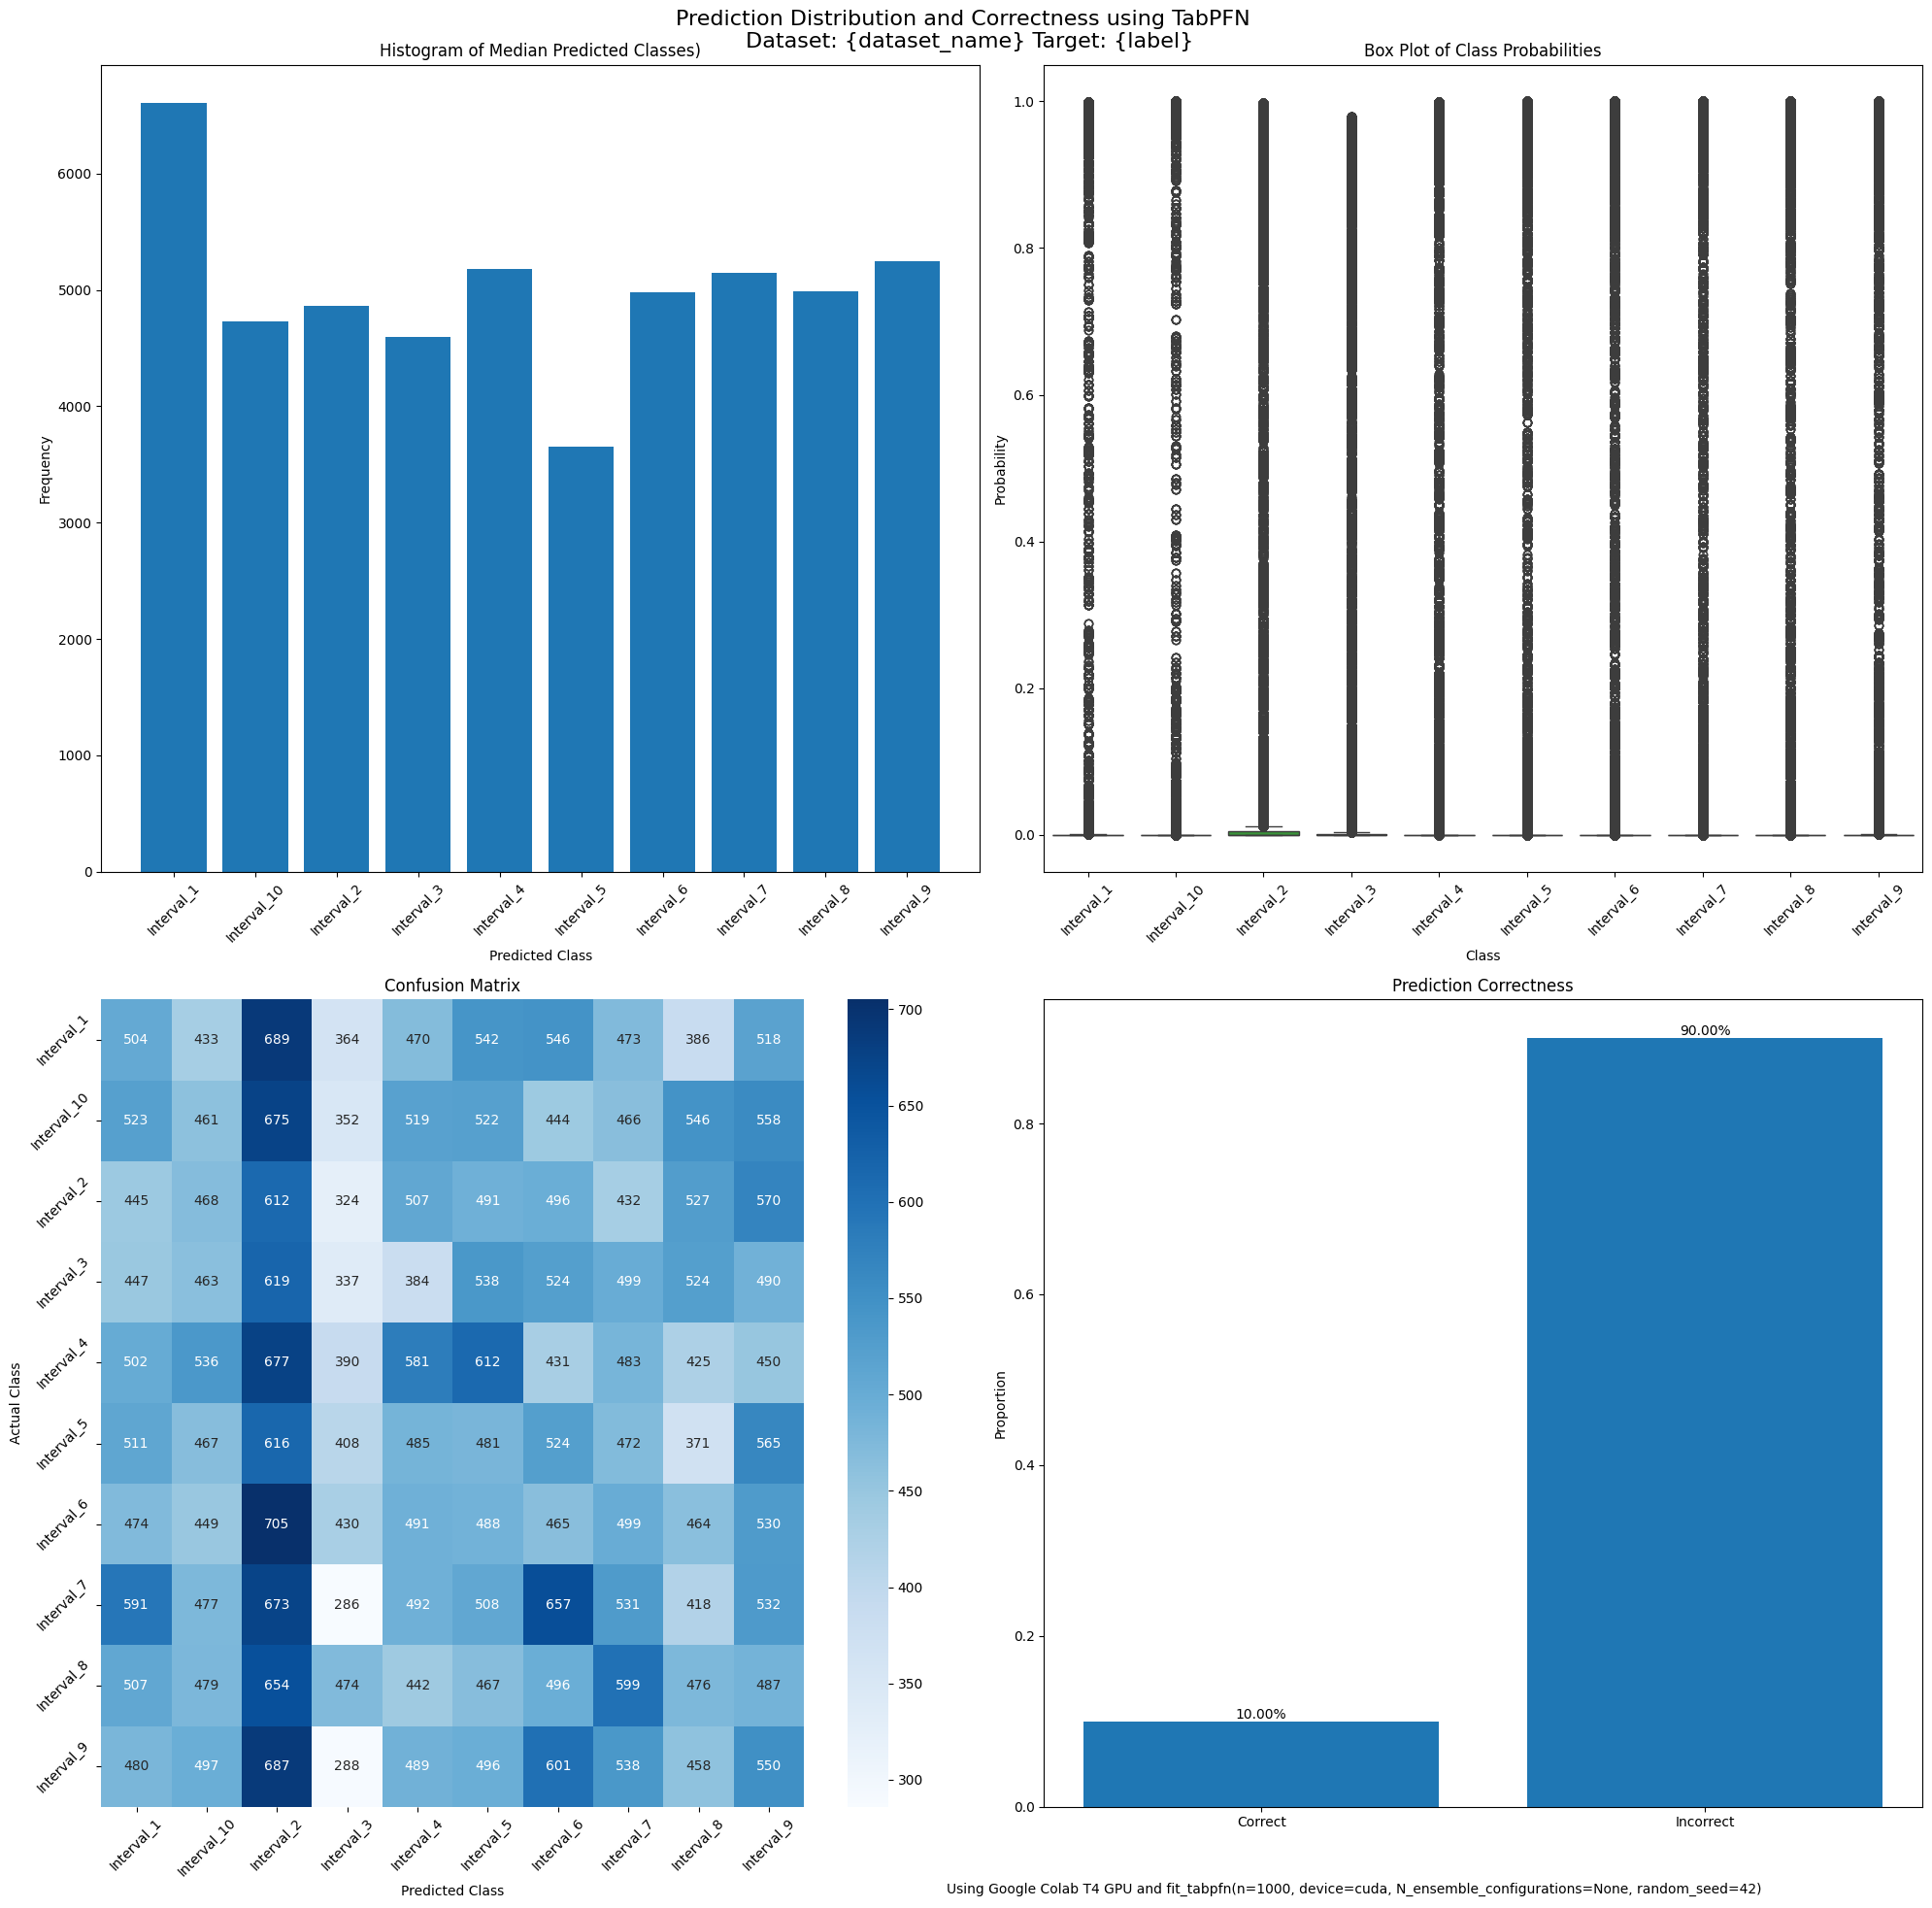

Training Set Summary:
Most common median predicted class: Interval_2
Average probability for most likely class: 0.9092
Accuracy: 0.1000


In [48]:
import numpy as np
from scipy.stats import median_abs_deviation

def batch_predict(classifier, data, batch_size=10000):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i+batch_size]
        batch_pred = classifier.predict_proba(batch)
        predictions.append(batch_pred)
    return np.concatenate(predictions)

def sample_predict_and_compare(classifier, data, full_data, target_column='interval_class', n_samples=50000, random_state=42):
    sampled_data = data.sample(n=min(n_samples, len(data)), random_state=random_state)
    sampled_indices = sampled_data.index
    predictions = batch_predict(classifier, sampled_data)

    # Get the actual intervals
    full_data = full_data.reset_index(drop=True)

    actual_intervals = full_data.loc[sampled_data.index, target_column]

    # If actual_intervals is a Series of lists, flatten it
    if isinstance(actual_intervals.iloc[0], list):
        actual_intervals = actual_intervals.apply(lambda x: x[0] if x else np.nan)

    # Ensure actual_intervals is a 1D numpy array
    actual_intervals = np.array(actual_intervals)

    return predictions, actual_intervals, sampled_data

# Predict on a sample of training data and get actual intervals
y_pred, actual_intervals_train, sampled_train = sample_predict_and_compare(
    classifier,
    train_for_feature_engineering,
    full_train_w_interval,
    target_column='interval_class'
)

# Visualization function
def visualize_prediction_distribution(y_pred, actual_intervals, class_labels):
    n_classes = len(class_labels)

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Prediction Distribution and Correctness using TabPFN \n Dataset: {dataset_name} Target: {label}', fontsize=16)

    fig.text(0.6, 0.01, 'Using Google Colab T4 GPU and fit_tabpfn(n=1000, device=cuda, N_ensemble_configurations=None, random_seed=42)', ha='center', fontsize=10)

    def get_median_interval(pred):
        return class_labels[np.argmax(pred)]

    train_medians = [get_median_interval(pred) for pred in y_pred]

    # Histogram for training set
    axs[0, 0].hist(train_medians, bins=n_classes, range=(0, n_classes), align='left', rwidth=0.8)
    axs[0, 0].set_title('Histogram of Median Predicted Classes)')
    axs[0, 0].set_xlabel('Predicted Class')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_xticks(range(n_classes))
    axs[0, 0].set_xticklabels(class_labels, rotation=45)

    # Box plot for training set
    sns.boxplot(data=y_pred, ax=axs[0, 1])
    axs[0, 1].set_title(f'Box Plot of Class Probabilities')
    axs[0, 1].set_xlabel('Class')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].set_xticklabels(class_labels, rotation=45)

    # Confusion matrix
    cm = confusion_matrix(actual_intervals, train_medians)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')
    axs[1, 0].set_xlabel('Predicted Class')
    axs[1, 0].set_ylabel('Actual Class')
    axs[1, 0].set_xticklabels(class_labels, rotation=45)
    axs[1, 0].set_yticklabels(class_labels, rotation=45)

    # Correctness bar plot
    correct = (np.array(train_medians) == np.array(actual_intervals))
    accuracy = correct.mean()
    axs[1, 1].bar(['Correct', 'Incorrect'], [accuracy, 1-accuracy])
    axs[1, 1].set_title('Prediction Correctness')
    axs[1, 1].set_ylabel('Proportion')
    for i, v in enumerate([accuracy, 1-accuracy]):
        axs[1, 1].text(i, v, f'{v:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("Training Set Summary:")
    print(f"Most common median predicted class: {max(set(train_medians), key=train_medians.count)}")
    print(f"Average probability for most likely class: {np.mean(np.max(y_pred, axis=1)):.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Run the visualization
class_labels = classifier.classes_  # Use the actual class labels from the classifier
visualize_prediction_distribution(y_pred, actual_intervals_train, class_labels)

In [ ]:
## Concat for autogluon

# without intervall_class
full_train_ag = pd.concat([full_train, tabpfn_predicted_train['interval_class_pred']], axis=1)

# Also concat test sets for AutoGluon

full_test_ag = pd.concat([tabpfn_preicted_test, full_test_y], axis=1)


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 618.00 MiB. GPU 

In [ ]:
print(full_train_ag.head())
print(full_test_ag.head())

# print unique values for interval_class_pred column

print(full_train_ag['interval_class_pred'].value_counts())
print(full_test_ag['interval_class_pred'].value_counts())

print(full_train_ag['interval_class'].value_counts())
print(full_test_ag['interval_class'].value_counts())


           oz1       oz2       oz3       oz4       oz5       oz6       oz9  \
7431  0.999078  0.177647  0.999093  0.996510  0.133333  0.000000  0.045455   
2900  0.998759  0.000000  0.997260  0.996325  0.133333  0.000000  0.590909   
978   0.999769  0.174118  0.999707  0.997143  0.000000  0.000000  0.000000   
2928  0.998759  0.000000  0.997260  0.996325  0.200000  0.028571  0.045455   
903   0.999286  0.174118  0.999364  0.996630  0.000000  0.028571  0.000000   

          oz10  oz11      oz12  ...  oz234     oz246     oz247  oz248  \
7431  0.000000   0.1  0.096154  ...    0.0  0.562353  0.028136  0.455   
2900  0.250000   0.2  0.000000  ...    0.0  0.248627  0.011586  0.000   
978   0.000000   0.0  0.173077  ...    0.0  0.641098  0.159550  0.700   
2928  0.083333   0.1  0.000000  ...    0.0  0.248627  0.032771  0.000   
903   0.000000   0.0  0.134615  ...    0.0  0.562353  0.081209  0.625   

         oz249     oz250     oz251     oz252  interval_class  \
7431  0.206943  0.127661  0.

KeyError: 'interval_class'

In [ ]:
## Evaluate the tabpfn classifier...

In [ ]:
## Training the AutoGluon predictor

model = fit_gluon(train_with_tab_pred, time_limit=100)
# Get the leaderboard
leaderboard = model.leaderboard(extra_info=['r2'])

No path specified. Models will be saved in: "AutogluonModels/ag-20240707_164256"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.95 GB / 12.67 GB (78.5%)
Disk Space Avail:   46.57 GB / 78.19 GB (59.6%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20240707_164256"
Train Data Rows:    79965
Train Data Columns: 64
Label Column:       oz252
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10128.84 MB
	Train Data (Original)  Memory Usage: 43.01 MB (0.4% of available memory)
	Inferring data type of each feature

[1000]	valid_set's l2: 9.31469e-06	valid_set's r2: 0.988283
[2000]	valid_set's l2: 4.54914e-06	valid_set's r2: 0.994278
[3000]	valid_set's l2: 2.4855e-06	valid_set's r2: 0.996874
[4000]	valid_set's l2: 1.49652e-06	valid_set's r2: 0.998118
[5000]	valid_set's l2: 9.6215e-07	valid_set's r2: 0.99879
[6000]	valid_set's l2: 6.55954e-07	valid_set's r2: 0.999175
[7000]	valid_set's l2: 4.73723e-07	valid_set's r2: 0.999404
[8000]	valid_set's l2: 3.66622e-07	valid_set's r2: 0.999539
[9000]	valid_set's l2: 2.99532e-07	valid_set's r2: 0.999623


	Ran out of time, early stopping on iteration 9019. Best iteration is:
	[9019]	valid_set's l2: 2.98339e-07	valid_set's r2: 0.999625
	0.9996	 = Validation score   (r2)
	98.72s	 = Training   runtime
	2.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 97.94s of the -7.69s of remaining time.
	Ensemble Weights: {'LightGBMXT': 0.957, 'KNeighborsUnif': 0.043}
	0.9996	 = Validation score   (r2)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 107.85s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 599.0 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240707_164256")


In [ ]:
# Evaluate the model

test_score, leaderboard, L2_diagram = evaluate_gluon(model, full_test)

display(L2_diagram)
print(f'Test score: {test_score}')
print(leaderboard.head())

# # Convert the leaderboard to a DataFrame
df = leaderboard.copy()

# Set the style of the plots
sns.set(style="whitegrid")

# Plot for validation score (r2)
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='score_val', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Validation Score (R2) by Model')
plt.xlabel('Model')
plt.ylabel('Validation Score (R2)')
plt.tight_layout()
plt.show()


KeyError: "1 required columns are missing from the provided dataset to transform using AutoMLPipelineFeatureGenerator. 1 missing columns: ['interval_class'] | 63 available columns: ['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz9', 'oz10', 'oz11', 'oz12', 'oz13', 'oz31', 'oz40', 'oz42', 'oz46', 'oz50', 'oz69', 'oz71', 'oz73', 'oz79', 'oz83', 'oz87', 'oz96', 'oz100', 'oz107', 'oz108', 'oz111', 'oz112', 'oz113', 'oz115', 'oz124', 'oz125', 'oz126', 'oz127', 'oz128', 'oz131', 'oz133', 'oz135', 'oz149', 'oz150', 'oz151', 'oz165', 'oz171', 'oz172', 'oz173', 'oz175', 'oz176', 'oz177', 'oz178', 'oz181', 'oz183', 'oz185', 'oz197', 'oz206', 'oz222', 'oz234', 'oz246', 'oz247', 'oz248', 'oz249', 'oz250', 'oz251', 'interval_class_pred']"

In [ ]:
## Make different predictiors for eventual ensemble (maybe different metrics, hyperparameters, etc.)

predictors = []

In [ ]:
## Function to load predictors

def load_predictors(start_time, end_time, folder='AutogluonModels'):
    """
    Load AutoGluon predictors created within a specified time interval.

    :param start_time: Start of the time interval (str in format 'YYYYMMDD_HHMMSS')
    :param end_time: End of the time interval (str in format 'YYYYMMDD_HHMMSS')
    :param folder: Folder containing the AutoGluon models
    :return: List of loaded predictors
    """
    start_datetime = datetime.strptime(start_time, '%Y%m%d_%H%M%S')
    end_datetime = datetime.strptime(end_time, '%Y%m%d_%H%M%S')

    predictors = []

    for item in os.listdir(folder):
        if item.startswith('ag-'):
            model_time_str = item.split('-')[1]
            model_time = datetime.strptime(model_time_str, '%Y%m%d_%H%M%S')

            if start_datetime <= model_time <= end_datetime:
                predictor_path = os.path.join(folder, item)
                predictor = TabularPredictor.load(predictor_path)
                predictors.append(predictor)

    return predictors

In [ ]:
## Creating easy average ensemble


start_time = '20240704_124200'
end_time = '20240704_125900'

loaded_predictors = load_predictors(start_time, end_time)

y_test = full_test[label_property]
full_test_X = full_test.drop(columns=[label_property])


# Simple averaging ensemble
avg_ensemble = 0

for i in loaded_predictors:
    avg_ensemble += i.predict(full_test_X)

ten_fold_ensemble = avg_ensemble / len(loaded_predictors)


# Calculate R2 score
r2 = r2_score(y_test, ten_fold_ensemble)

print(f'R2 score: {r2}')

In [ ]:
## creating more complex ensemble...